<a href="https://colab.research.google.com/github/HazelvdW/context-framed-listening/blob/main/framed_listening_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framed Listening: **TF-IDF analyses**
> By **Hazel A. van der Walle** (PhD student, Music, Durham University), September 2025.

This notebook analyses semantic similarity between music-evoked thought (MET)
descriptions at the aggregated document level to answer: "Does context cue
influence METs more than the music itself?"

Analysis approach:
- Works with aggregated documents (called "METdocs") ONLY
  - TF-IDF is a bag-of-words method optimized for document-level analysis with
    sufficient word overlap. Individual short texts (10-50 words) produce extremely
    sparse vectors with minimal lexical overlap, resulting in artificially low
    similarity values that do not reflect semantic relationships.
  - BERT and Word2Vec handle individual-level analysis as they capture semantic
    meaning beyond exact word matches.
- Aggregates all thoughts from each clip-context pair into documents (N=64)
- Calculates pairwise cosine similarities between METdocs
- Categorises document pairs by their stimuli conditions to compare similarity distributions
- Tests whether aggregated thoughts are more similar when sharing music vs sharing context

Key comparisons:
1. Same clip + different context VS Different clip + same context
   → Does music or context drive thought similarity at the document level?
2. Within vs between genre/context/clip conditions
   → What factors influence semantic coherence in aggregated METs?

Note: This document-level analysis complements the individual-level analyses
conducted with BERT and Word2Vec, providing a lexical perspective on semantic patterns.

---

All datasets generated and used for this study are openly available on GitHub https://github.com/HazelvdW/context-framed-listening.

In [1]:
!rm -r context-framed-listening
# Clone the GitHub repository
!git clone https://github.com/HazelvdW/context-framed-listening.git

Cloning into 'context-framed-listening'...
remote: Enumerating objects: 345, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 345 (delta 3), reused 0 (delta 0), pack-reused 335 (from 1)
Receiving objects: 100% (345/345), 58.61 MiB | 21.04 MiB/s, done.
Resolving deltas: 100% (172/172), done.


Refresh files to see **"context-framed-listening"**.


---

## Setup

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Load in the data file "**dataMET_preprocessed.csv**" that contains the preprocessed text data of participants' thought desciptions, generated using the code notebook titled [framed_listening_text_prep](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_text_prep.ipynb)

In [3]:
dataMETpre = pd.read_csv("/content/context-framed-listening/NLP_outputs/dataMET_preprocessed.csv")

# Use the TF-IDF-appropriate preprocessing column (aggressive filtering)
thought_column = 'METdescr_prepLVL2'

print(f"Total individual MET descriptions for analysis: {len(dataMETpre)}")
print(f"Unique clips: {dataMETpre['clip_name'].nunique()}")
print(f"Unique contexts: {dataMETpre['context_word'].nunique()}")
print(f"Unique clip-context pairs: {dataMETpre['clip_context_PAIR'].nunique()}")

Total individual MET descriptions for analysis: 1962
Unique clips: 16
Unique contexts: 4
Unique clip-context pairs: 64


---
## ANALYSIS AT COMBINED METdoc LEVEL

TF-IDF (Term Frequency-Inverse Document Frequency) is a bag-of-words approach
that weights words by their importance within documents relative to a corpus.
This method is optimized for document-level analysis where texts are long enough
to contain sufficient word overlap for meaningful similarity comparisons.

Analysis structure:
- Aggregates all thoughts from each clip-context pair into documents (N=64)
- Each METdoc represents the collective semantic profile of one experimental condition
- Compares documents using cosine similarity of TF-IDF vectors
- Uses identical condition categories as BERT and Word2Vec for cross-method comparison

Purpose: Examine lexical similarity patterns at the aggregated level
- Shows which condition pairs share similar vocabulary and word usage patterns
- Complements semantic similarity analyses from BERT and Word2Vec
- Useful for understanding document-level semantic profiles


In [4]:
# Load aggregated METdocs
print("Loading aggregated METdocs...")
METdocs = pd.read_csv('/content/context-framed-listening/NLP_outputs/METdocsLVL2.csv')

# Use the TF-IDF-appropriate preprocessing column
text_column = 'METdescr_prepLVL2'

print(f"Total METdocs (clip-context pairs): {len(METdocs)}")
print(f"Unique clips: {METdocs['clip_name'].nunique()}")
print(f"Unique contexts: {METdocs['context_word'].nunique()}")

Loading aggregated METdocs...
Total METdocs (clip-context pairs): 64
Unique clips: 16
Unique contexts: 4


### TF-IDF Vectorisation

In [5]:
print("\nComputing TF-IDF vectors for aggregated METdocs...")

# Initialise TF-IDF vectorizer
tfidf_vectorizer_docs = TfidfVectorizer(sublinear_tf=False)

# Fit and transform METdocs
tfidf_matrix_docs = tfidf_vectorizer_docs.fit_transform(METdocs[text_column].astype(str))

print(f"TF-IDF matrix shape: {tfidf_matrix_docs.shape}")
print(f"Number of unique terms: {len(tfidf_vectorizer_docs.get_feature_names_out())}")

# Save TF-IDF scores for METdocs
df_TFIDF_docs = pd.DataFrame(
    tfidf_matrix_docs.toarray(),
    columns=tfidf_vectorizer_docs.get_feature_names_out(),
    index=METdocs['ClipContext_pair']
)
df_TFIDF_docs.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_scores_METdocs.csv',
                      encoding='utf-8')


Computing TF-IDF vectors for aggregated METdocs...
TF-IDF matrix shape: (64, 3325)
Number of unique terms: 3325


### Cosine Similarity Matrix


Calculating cosine similarity matrix...

TF-IDF Cosine Similarity Matrix (METdocs level):


ClipContext_pair,BAR-80s_LOW_02,BAR-80s_LOW_06,BAR-80s_MED_08,BAR-80s_MED_13,BAR-Ele_LOW_09,BAR-Ele_LOW_14,BAR-Ele_MED_19,BAR-Ele_MED_20,BAR-Jaz_LOW_19,BAR-Jaz_LOW_21,...,VIDEOGAME-Ele_MED_19,VIDEOGAME-Ele_MED_20,VIDEOGAME-Jaz_LOW_19,VIDEOGAME-Jaz_LOW_21,VIDEOGAME-Jaz_MED_02,VIDEOGAME-Jaz_MED_07,VIDEOGAME-Met_LOW_09,VIDEOGAME-Met_LOW_14,VIDEOGAME-Met_MED_19,VIDEOGAME-Met_MED_20
ClipContext_pair,,,,,,,,,,,,,,,,,,,,,
BAR-80s_LOW_02,1.000000,0.341980,0.358179,0.358328,0.344184,0.345180,0.408953,0.340433,0.321841,0.359571,...,0.392228,0.346242,0.286943,0.334202,0.380768,0.437105,0.332314,0.267711,0.310773,0.310947
BAR-80s_LOW_06,0.341980,1.000000,0.426238,0.335442,0.355636,0.407451,0.313701,0.325606,0.336328,0.440361,...,0.298549,0.266112,0.287858,0.286771,0.371370,0.391684,0.296229,0.230518,0.260956,0.274753
BAR-80s_MED_08,0.358179,0.426238,1.000000,0.424640,0.387232,0.445359,0.362594,0.360172,0.401012,0.452967,...,0.387771,0.315025,0.333351,0.403461,0.407920,0.394449,0.358442,0.303518,0.344153,0.332642
BAR-80s_MED_13,0.358328,0.335442,0.424640,1.000000,0.376855,0.370450,0.375945,0.321061,0.410123,0.362957,...,0.386010,0.357943,0.376403,0.361567,0.383822,0.385968,0.368329,0.287007,0.340189,0.336044
BAR-Ele_LOW_09,0.344184,0.355636,0.387232,0.376855,1.000000,0.413536,0.368102,0.331279,0.354978,0.395798,...,0.354968,0.334759,0.351387,0.348050,0.348303,0.333701,0.376711,0.329743,0.387856,0.355314


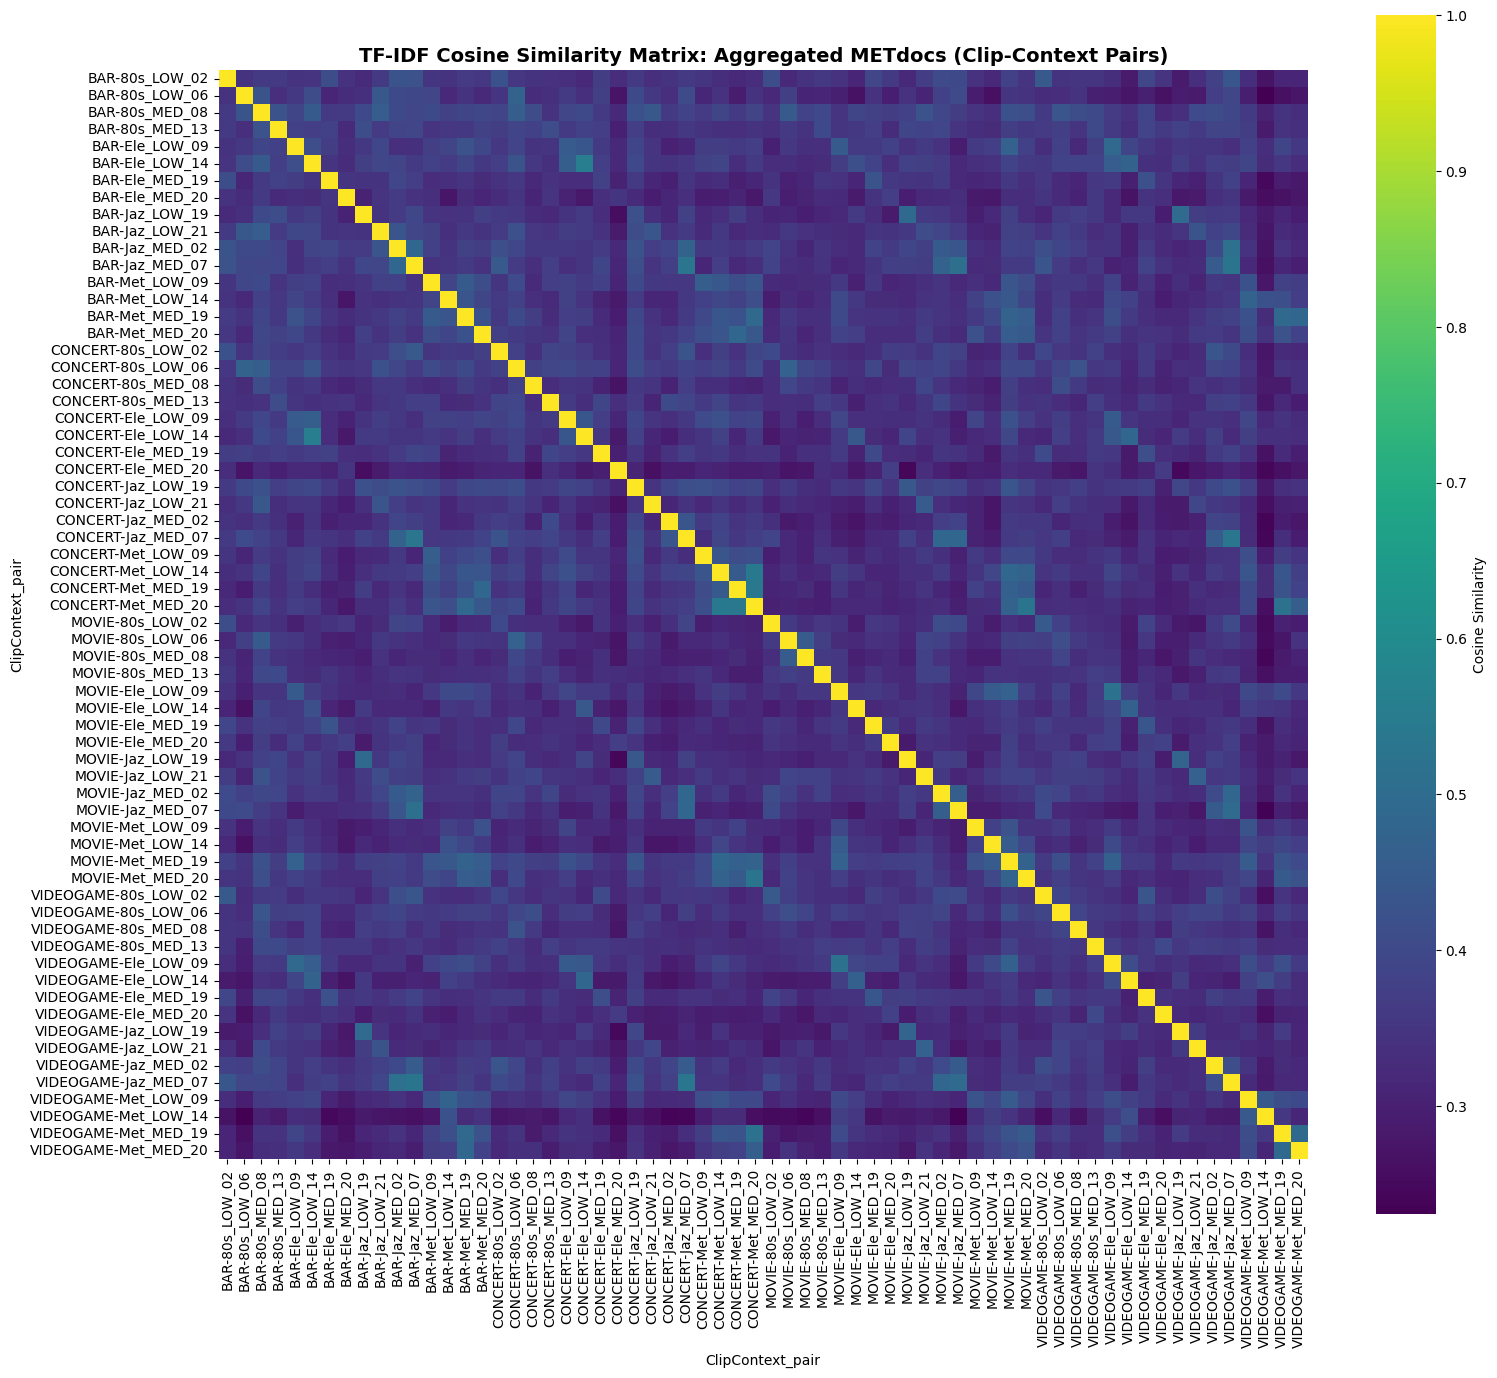

In [6]:
print("\nCalculating cosine similarity matrix...")
cosineMatrix_TFIDF = cosine_similarity(tfidf_matrix_docs, tfidf_matrix_docs)

# Create labeled DataFrame
cosineMatrix_TFIDF_df = pd.DataFrame(
    cosineMatrix_TFIDF,
    index=METdocs['ClipContext_pair'],
    columns=METdocs['ClipContext_pair']
)

# Save cosine similarity matrix
cosineMatrix_TFIDF_df.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/cosineMatrix_TFIDF_METdocs.csv',
                               encoding='utf-8')

print("\nTF-IDF Cosine Similarity Matrix (METdocs level):")
display(cosineMatrix_TFIDF_df.head())

plt.figure(figsize=(16, 14))
sns.heatmap(cosineMatrix_TFIDF_df, cmap='viridis', annot=False, square=True,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('TF-IDF Cosine Similarity Matrix: Aggregated METdocs (Clip-Context Pairs)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/heatmap_TFIDF_METdocs.png',
            dpi=300, bbox_inches='tight')
plt.show()

### Similarity Values by Condition

In [7]:
print("\nExtracting similarity values by condition...")
print("Using IDENTICAL conditions as individual thought-level analysis...")

# Extract metadata
clips = METdocs['clip_name'].values
contexts = METdocs['context_word'].values
genres = METdocs['genre_code'].values

# Initialise storage for similarity measures
similarity_data = {
    'doc_i': [],
    'doc_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'condition': []
}

# Iterate through upper triangle of similarity matrix
n_docs = len(METdocs)
print(f"Processing {(n_docs * (n_docs - 1)) // 2} unique document pairs...")

for i in range(n_docs):
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{n_docs} documents...")

    for j in range(i + 1, n_docs):
        # Extract similarity value
        sim_value = cosineMatrix_TFIDF[i, j]

        # Determine conditions (IDENTICAL to individual-level analysis)
        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]

        # Categorise into SAME conditions as individual thought analysis
        if same_clip and same_context:
            condition = 'same_clip_same_context'
        elif same_clip and not same_context:
            condition = 'same_clip_diff_context'  # MUSIC influence
        elif not same_clip and same_context:
            condition = 'diff_clip_same_context'  # CONTEXT influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diff_clip_diff_context_same_genre'
            else:
                condition = 'diff_clip_diff_context_diff_genre'

        # Store data
        similarity_data['doc_i'].append(i)
        similarity_data['doc_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df_docs = pd.DataFrame(similarity_data)
sim_df_docs.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/similarity_by_condition_TFIDF_METdocs.csv',
                    index=False)

print("\nMETdocs-level similarity measures extracted:")
print(sim_df_docs.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))



Extracting similarity values by condition...
Using IDENTICAL conditions as individual thought-level analysis...
Processing 2016 unique document pairs...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...

METdocs-level similarity measures extracted:
                                   count      mean       std       min  \
condition                                                                
diff_clip_diff_context_diff_genre   1152  0.335158  0.033651  0.230518   
diff_clip_diff_context_same_genre    288  0.363182  0.048555  0.257666   
diff_clip_same_context               480  0.354024  0.040283  0.259544   
same_clip_diff_context                96  0.422625  0.050381  0.326656   

                                        max  
condition                                    
diff_clip_diff_context_diff_genre  0.465631  
diff_clip_diff_context_same_gen

### STATISTICAL ANALYSES

1. PRIMARY RESEARCH QUESTION
2. Genre Effects
3. Context Specificity
4. Music Specificity
5. OMNIBUS TEST
6. Condition Means Ranking

In [8]:
def compare_conditions(df, cond1, cond2, label1, label2):
    """Compare two conditions with t-test and effect size."""
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    t_stat, p_value = stats.ttest_ind(data1, data2)

    # Cohen's d
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }

# Store all comparison results
comparisons_docs = []


# 1. PRIMARY RESEARCH QUESTION
# ---------------------------------------------------------------------------
print("\n1. PRIMARY QUESTION: Music vs Context Influence (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df_docs,
    'same_clip_diff_context',
    'diff_clip_same_context',
    'Same Music, Diff Context',
    'Diff Music, Same Context'
)
comparisons_docs.append(comp)

print(f"\nSame music, different context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different music, same context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"Difference: {comp['diff']:.4f}")
print(f"t({comp['n1'] + comp['n2'] - 2}) = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}")
print(f"Cohen's d = {comp['d']:.3f}")

if comp['mean1'] > comp['mean2']:
    print("\n→ At METdocs level: MUSIC drives similarity MORE than context")
else:
    print("\n→ At METdocs level: CONTEXT drives similarity MORE than music")


# 2. GENRE EFFECTS
# ---------------------------------------------------------------------------
print("\n\n2. GENRE EFFECTS (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df_docs,
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre',
    'Different everything, Same Genre',
    'Different everything, Different Genre'
)
comparisons_docs.append(comp)

print(f"\nSame genre (diff clip & context): M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different genre (diff clip & context): M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

if comp['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence at document level")
else:
    print("\n→ Genre does NOT significantly affect document-level similarity")


# 3. CONTEXT SPECIFICITY
# ---------------------------------------------------------------------------
print("\n\n3. CONTEXT SPECIFICITY (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df_docs,
    'same_clip_same_context',
    'diff_clip_same_context',
    'Same Context & Same Clip',
    'Same Context, Diff Clip'
)
comparisons_docs.append(comp)

print(f"\nSame context + same clip: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same context, different clip: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")


# 4. MUSIC SPECIFICITY
# ---------------------------------------------------------------------------
print("\n\n4. MUSIC SPECIFICITY (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df_docs,
    'same_clip_same_context',
    'same_clip_diff_context',
    'Same Clip & Same Context',
    'Same Clip, Diff Context'
)
comparisons_docs.append(comp)

print(f"\nSame clip + same context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same clip, different context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")


# 5. OMNIBUS TEST
# ---------------------------------------------------------------------------
print("\n\n5. OMNIBUS TEST: Do conditions differ overall? (METdocs level)")
print("-" * 70)

conditions_docs = sim_df_docs['condition'].unique()
groups_docs = [sim_df_docs[sim_df_docs['condition'] == cond]['similarity'] for cond in conditions_docs]
f_stat_docs, p_anova_docs = stats.f_oneway(*groups_docs)

print(f"\nOne-way ANOVA across all {len(conditions_docs)} conditions:")
print(f"F({len(conditions_docs)-1}, {len(sim_df_docs)-len(conditions_docs)}) = {f_stat_docs:.3f}, p = {p_anova_docs:.4e}")

if p_anova_docs < 0.001:
    print("\n→ Conditions are HIGHLY significantly different at document level")
else:
    print("\n→ Conditions show significant differences" if p_anova_docs < 0.05 else "→ No significant differences")


# 6. CONDITION MEANS RANKING
# ---------------------------------------------------------------------------
print("\n\n6. CONDITION MEANS RANKING (METdocs level)")
print("-" * 70)

condition_means_docs = sim_df_docs.groupby('condition')['similarity'].agg(['mean', 'std', 'count'])
condition_means_docs = condition_means_docs.sort_values('mean', ascending=False)

print("\nCondition means (ranked):")
print(condition_means_docs)

# Save comparison results
comparisons_df_docs = pd.DataFrame(comparisons_docs)
comparisons_df_docs = comparisons_df_docs.sort_values('d', key=abs, ascending=False)
comparisons_df_docs.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/statistical_comparisons_TFIDF_METdocs.csv',
                            index=False)

print("\n\nKey comparisons ranked by effect size:")
print(comparisons_df_docs[['comparison', 'diff', 'd', 'p', 'sig']])


1. PRIMARY QUESTION: Music vs Context Influence (METdocs level)
----------------------------------------------------------------------

Same music, different context: M=0.4226 (N=96)
Different music, same context: M=0.3540 (N=480)
Difference: 0.0686
t(574) = 14.567, p = 0.0000 ***
Cohen's d = 1.504

→ At METdocs level: MUSIC drives similarity MORE than context


2. GENRE EFFECTS (METdocs level)
----------------------------------------------------------------------

Same genre (diff clip & context): M=0.3632 (N=288)
Different genre (diff clip & context): M=0.3352 (N=1152)
t = 11.464, p = 0.0000 ***, d = 0.671

→ Genre creates semantic coherence at document level


3. CONTEXT SPECIFICITY (METdocs level)
----------------------------------------------------------------------

Same context + same clip: M=nan (N=0)
Same context, different clip: M=0.3540 (N=480)
t = nan, p = nan n.s., d = nan


4. MUSIC SPECIFICITY (METdocs level)
-------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


### Visualisations

1. PRIMARY COMPARISON: Music vs Context
2. ALL CONDITIONS comparison
3. Bar plot with means and 95% CI
4. Distribution comparison histogram
5. HIERARCHICAL comparison
6. Genre effects visualisation
7. Heatmap


Generating visualisations...


/tmp/ipython-input-3248926661.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])


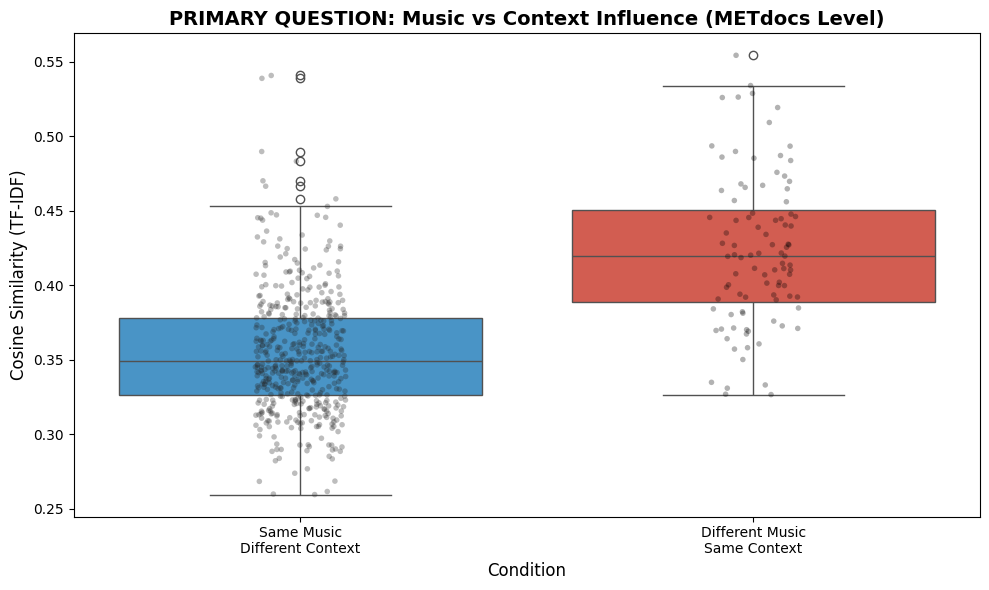

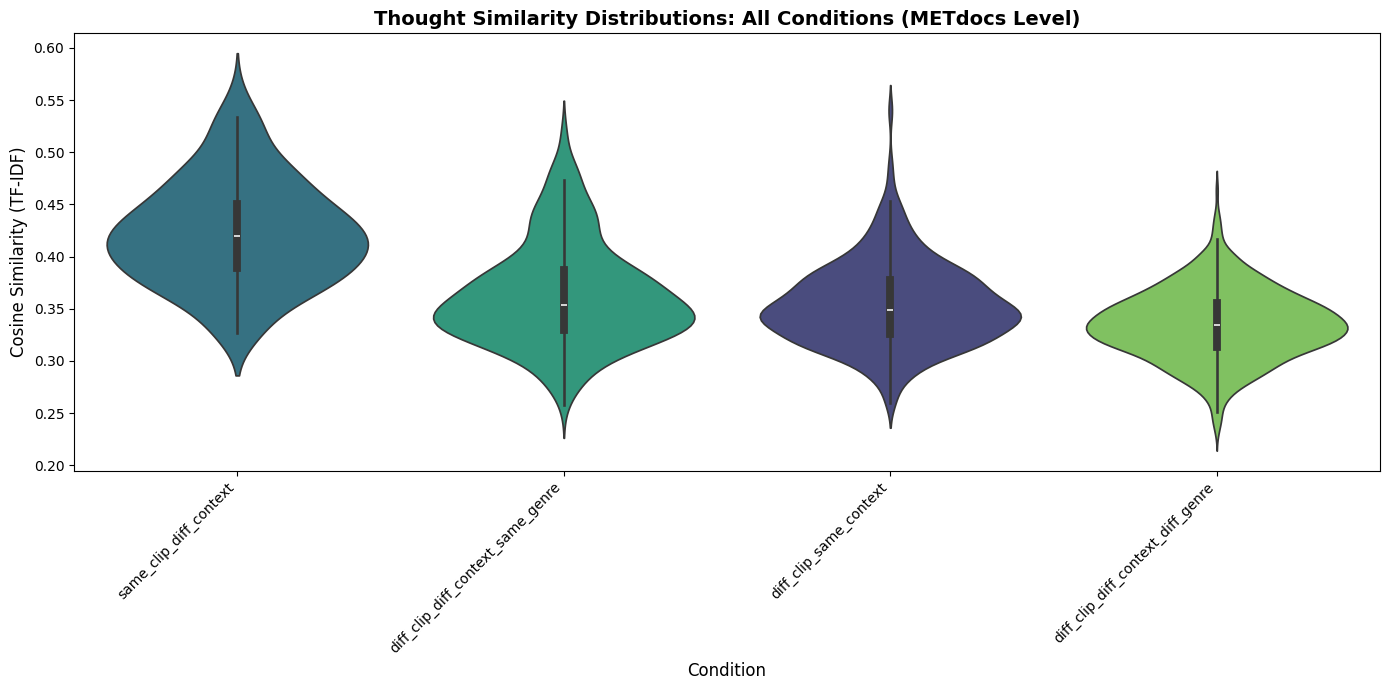

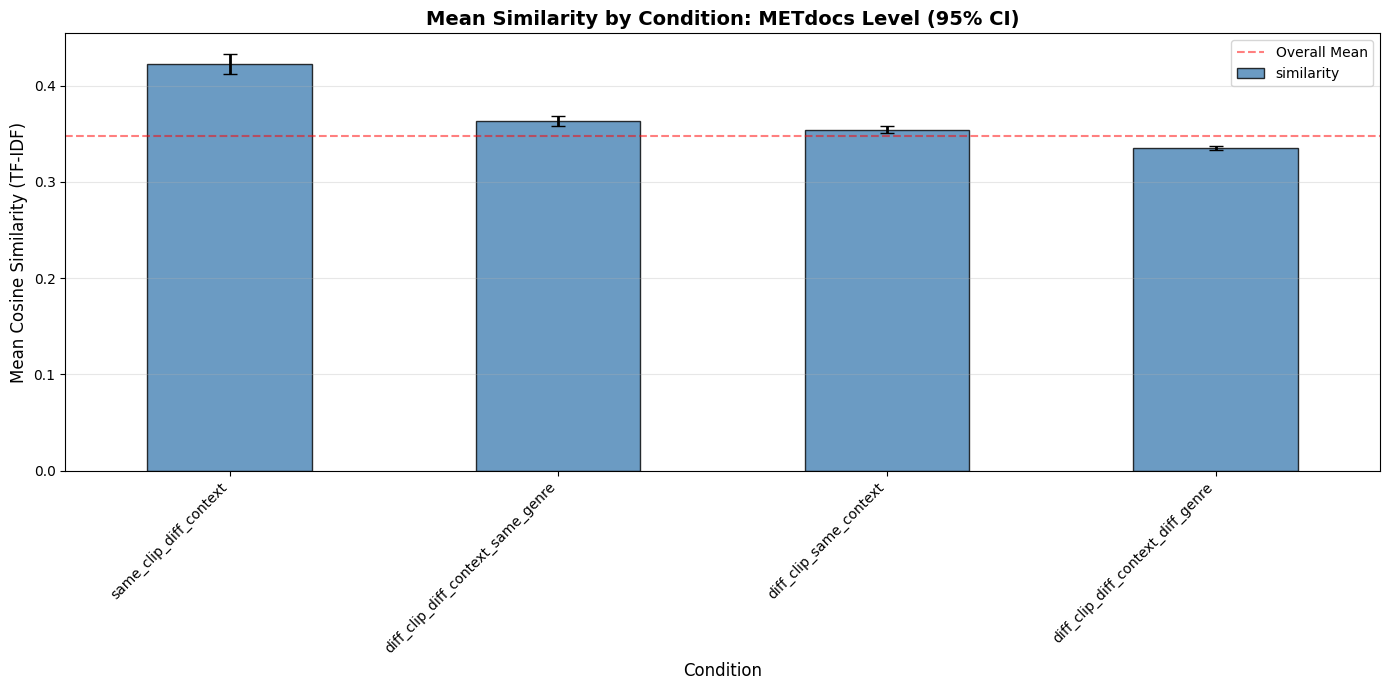

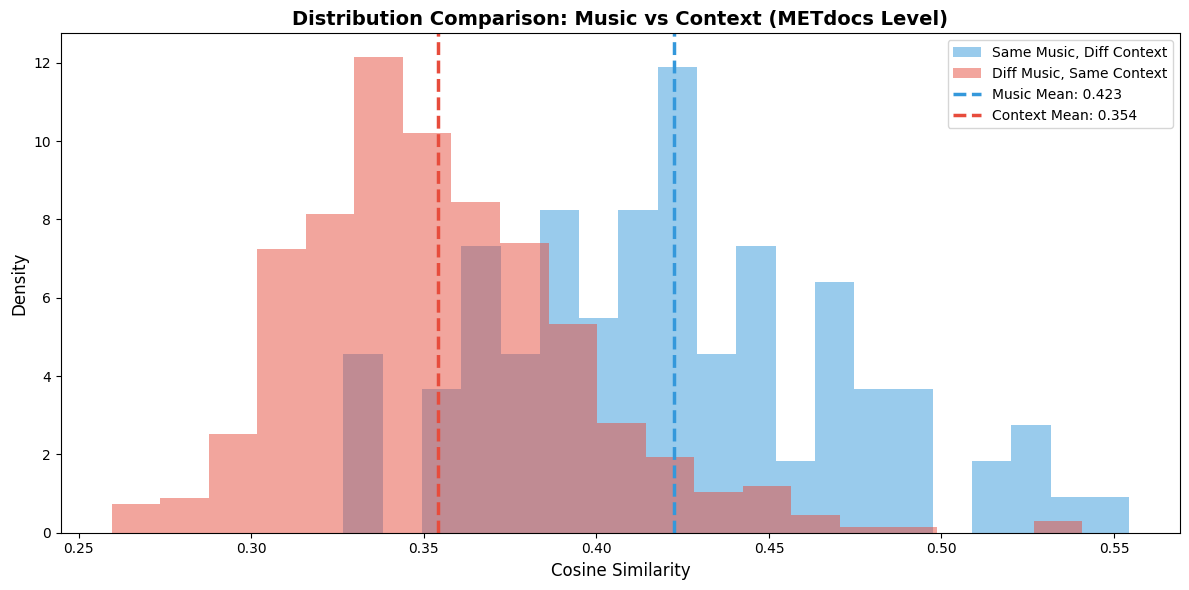

/tmp/ipython-input-3248926661.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0, ha='center')


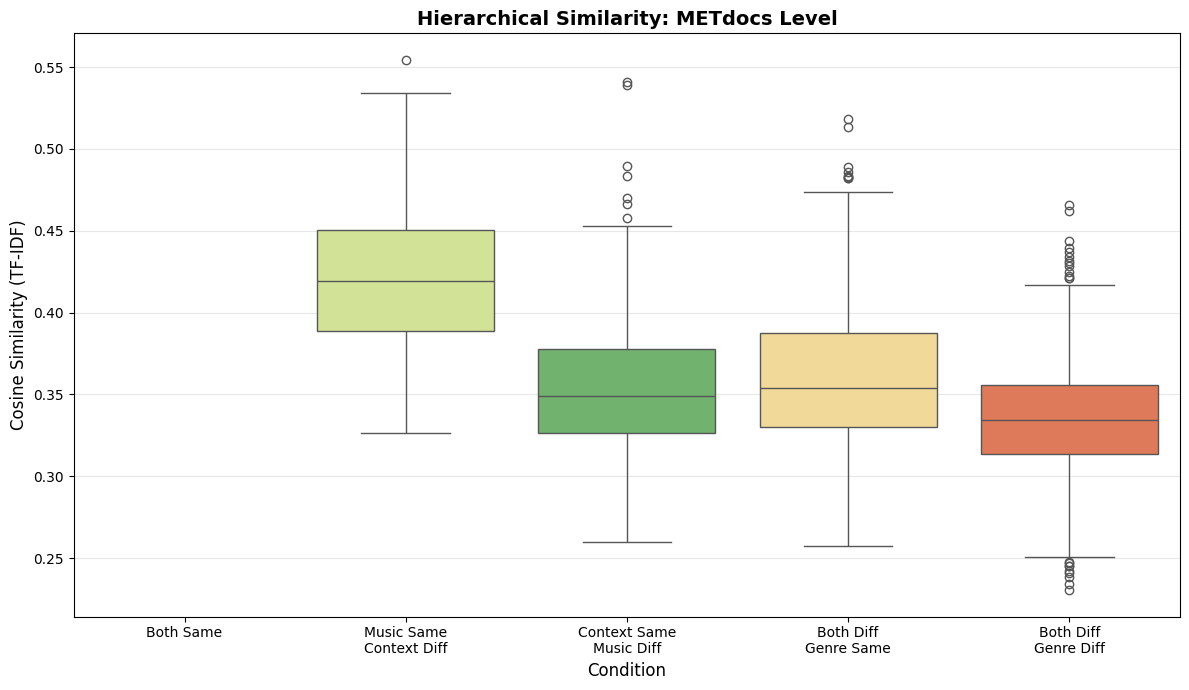

/tmp/ipython-input-3248926661.py:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Same Genre', 'Different Genre'])


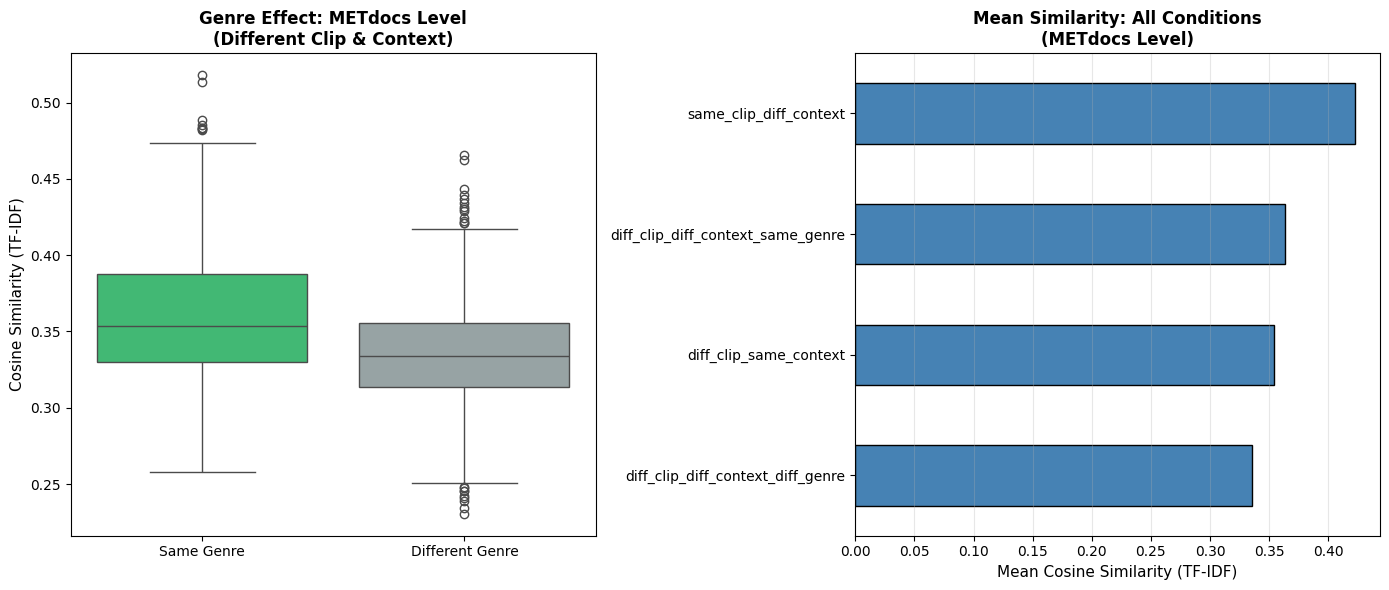

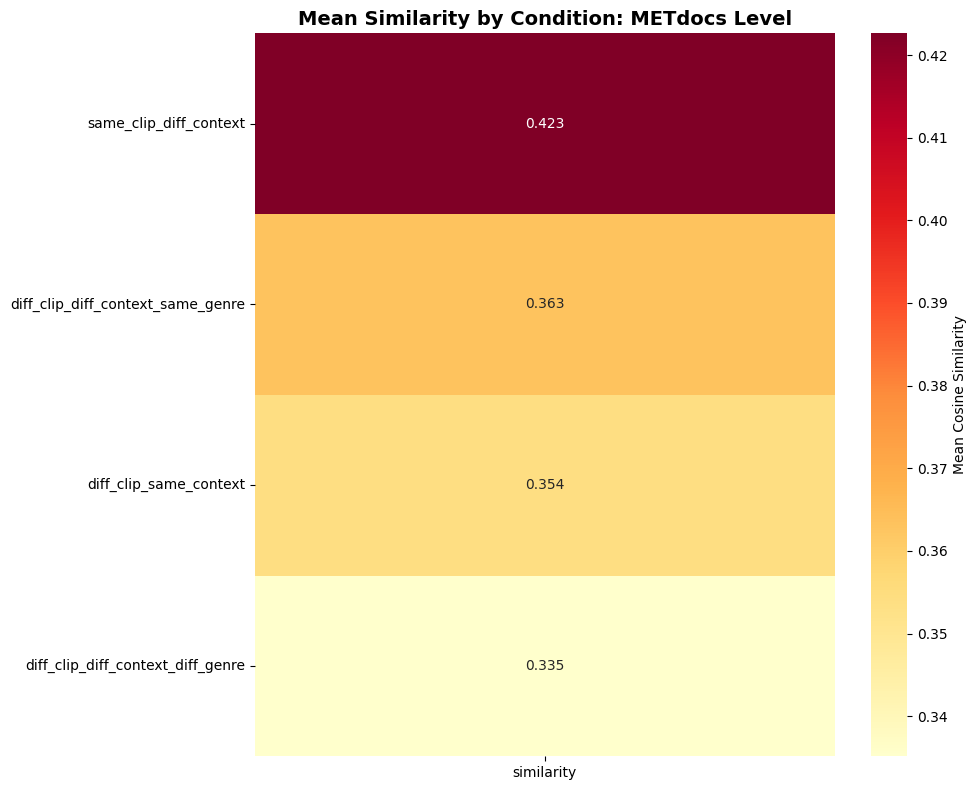

In [9]:
print("\nGenerating visualisations...")

# Get data for key conditions
music_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']
same_both_docs = sim_df_docs[sim_df_docs['condition'] == 'same_clip_same_context']['similarity']
diff_both_same_genre_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_diff_context_same_genre']['similarity']
diff_both_diff_genre_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_diff_context_diff_genre']['similarity']


# 1. PRIMARY COMPARISON: Music vs Context
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = sim_df_docs[sim_df_docs['condition'].isin(['same_clip_diff_context', 'diff_clip_same_context'])]
sns.boxplot(data=comparison_data, x='condition', y='similarity', ax=ax,
            hue='condition', palette=['#3498db', '#e74c3c'])
sns.stripplot(data=comparison_data, x='condition', y='similarity', ax=ax,
              hue='condition', palette='dark:black', alpha=0.3, size=4)
ax.set_title('PRIMARY QUESTION: Music vs Context Influence (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (TF-IDF)', fontsize=12)
ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/metdocs_01_music_vs_context_boxplot.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 2. ALL CONDITIONS comparison
fig, ax = plt.subplots(figsize=(14, 7))
condition_order = sim_df_docs.groupby('condition')['similarity'].mean().sort_values(ascending=False).index
sns.violinplot(data=sim_df_docs, x='condition', y='similarity', ax=ax, order=condition_order,
               hue='condition', palette='viridis')
ax.set_title('Thought Similarity Distributions: All Conditions (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (TF-IDF)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/metdocs_02_all_conditions_violin.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 3. Bar plot with means and 95% CI
fig, ax = plt.subplots(figsize=(14, 7))
means = sim_df_docs.groupby('condition')['similarity'].mean().sort_values(ascending=False)
sems = sim_df_docs.groupby('condition')['similarity'].sem()
ci95 = sems * 1.96

means.plot(kind='bar', ax=ax, yerr=ci95, capsize=5, color='steelblue',
           edgecolor='black', alpha=0.8, error_kw={'linewidth': 2})
ax.set_title('Mean Similarity by Condition: METdocs Level (95% CI)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Mean Cosine Similarity (TF-IDF)', fontsize=12)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=sim_df_docs['similarity'].mean(), color='red', linestyle='--',
           alpha=0.5, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/metdocs_03_condition_means_barplot.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 4. Distribution comparison histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(music_driven_docs, bins=20, alpha=0.5, label='Same Music, Diff Context',
        color='#3498db', density=True)
ax.hist(context_driven_docs, bins=20, alpha=0.5, label='Diff Music, Same Context',
        color='#e74c3c', density=True)
ax.axvline(music_driven_docs.mean(), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Music Mean: {music_driven_docs.mean():.3f}')
ax.axvline(context_driven_docs.mean(), color='#e74c3c', linestyle='--', linewidth=2.5,
           label=f'Context Mean: {context_driven_docs.mean():.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison: Music vs Context (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/metdocs_04_music_vs_context_histogram.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 5. HIERARCHICAL comparison
fig, ax = plt.subplots(figsize=(12, 7))
hierarchical_data = sim_df_docs[sim_df_docs['condition'].isin([
    'same_clip_same_context',
    'same_clip_diff_context',
    'diff_clip_same_context',
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre'
])]

order = ['same_clip_same_context', 'same_clip_diff_context', 'diff_clip_same_context',
         'diff_clip_diff_context_same_genre', 'diff_clip_diff_context_diff_genre']
labels = ['Both Same', 'Music Same\nContext Diff', 'Context Same\nMusic Diff',
          'Both Diff\nGenre Same', 'Both Diff\nGenre Diff']

sns.boxplot(data=hierarchical_data, x='condition', y='similarity', ax=ax,
            order=order, hue='condition', palette='RdYlGn_r')
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title('Hierarchical Similarity: METdocs Level', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (TF-IDF)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/metdocs_05_hierarchical_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 6. Genre effects visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

genre_comparison = sim_df_docs[sim_df_docs['condition'].isin([
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre'
])]
sns.boxplot(data=genre_comparison, x='condition', y='similarity', ax=axes[0],
            hue='condition', palette=['#2ecc71', '#95a5a6'])
axes[0].set_title('Genre Effect: METdocs Level\n(Different Clip & Context)',
                  fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Same Genre', 'Different Genre'])
axes[0].set_ylabel('Cosine Similarity (TF-IDF)', fontsize=11)
axes[0].set_xlabel('')

all_conditions_means = sim_df_docs.groupby('condition')['similarity'].mean()
all_conditions_means.sort_values(ascending=True).plot(kind='barh', ax=axes[1],
                                                       color='steelblue', edgecolor='black')
axes[1].set_title('Mean Similarity: All Conditions\n(METdocs Level)',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Cosine Similarity (TF-IDF)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/metdocs_06_genre_effects_summary.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 7. Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
condition_pivot = sim_df_docs.pivot_table(values='similarity',
                                           index='condition',
                                           aggfunc='mean').sort_values('similarity', ascending=False)
sns.heatmap(condition_pivot, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Cosine Similarity'}, ax=ax)
ax.set_title('Mean Similarity by Condition: METdocs Level', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/metdocs_07_condition_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.show()


### SUMMARY

In [10]:
print("\n" + "-"*70)
print("METDOCS-LEVEL ANALYSIS COMPLETE")
print("-"*70)

print("\nOutput files saved:")
print("  Data files:")
print("    - TFIDF_scores_METdocs.csv")
print("    - cosineMatrix_TFIDF_METdocs.csv")
print("    - similarity_by_condition_TFIDF_METdocs.csv")
print("    - statistical_comparisons_TFIDF_METdocs.csv")

print("\n  Visualisations:")
print("    - heatmap_TFIDF_METdocs.png")
print("    - metdocs_01_music_vs_context_boxplot.png")
print("    - metdocs_02_all_conditions_violin.png")
print("    - metdocs_03_condition_means_barplot.png")
print("    - metdocs_04_music_vs_context_histogram.png")
print("    - metdocs_05_hierarchical_comparison.png")
print("    - metdocs_06_genre_effects_summary.png")
print("    - metdocs_07_condition_heatmap.png")

print("\n" + "-"*70)
print("KEY FINDINGS SUMMARY (METdocs Level)")
print("-"*70)

music_driven_summary = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven_summary = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']
diff = music_driven_summary.mean() - context_driven_summary.mean()
t_stat, p_value = stats.ttest_ind(music_driven_summary, context_driven_summary)
effect_size = diff / np.sqrt((music_driven_summary.std()**2 + context_driven_summary.std()**2) / 2)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context")
if abs(diff) < 0.01:
    print(f"   → Music and context have EQUIVALENT influence (d={effect_size:.3f})")
elif music_driven_summary.mean() > context_driven_summary.mean():
    print(f"   → MUSIC drives similarity MORE than context")
    print(f"   → Difference: {diff:.4f} (d={effect_size:.3f}, p={p_value:.4f})")
else:
    print(f"   → CONTEXT drives similarity MORE than music")
    print(f"   → Difference: {abs(diff):.4f} (d={abs(effect_size):.3f}, p={p_value:.4f})")

same_genre = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_diff_context_same_genre']['similarity'].mean()
diff_genre = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_diff_context_diff_genre']['similarity'].mean()
print(f"\n2. GENRE EFFECTS")
print(f"   → Same genre: M={same_genre:.4f}")
print(f"   → Different genre: M={diff_genre:.4f}")
print(f"   → Difference: {same_genre - diff_genre:.4f}")

if len(same_both_docs) > 0:
    print(f"\n3. BASELINE (identical clip-context pairs)")
    print(f"   → Note: Same clip + same context = same document (N={len(same_both_docs)})")
    print(f"   → Mean similarity: {same_both_docs.mean():.4f}")

print("\n" + "-"*70)
print("METHODOLOGICAL NOTE:")
print("-"*70)
print("TF-IDF analysis was conducted ONLY at the document level because:")
print("\n  1. TF-IDF is a bag-of-words approach requiring lexical word overlap")
print("  2. Individual thoughts (10-50 words) are too short for reliable TF-IDF")
print("  3. Short texts produce extremely sparse vectors (mostly zeros)")
print("  4. Individual-level analysis showed artificially low similarities (M~0.01)")
print("     due to minimal word overlap between short texts")
print("\n  → BERT and Word2Vec were used for individual-level analysis as they")
print("     capture semantic meaning beyond exact word matches")
print("  → TF-IDF complements these methods at the document level with lexical")
print("     similarity patterns based on word usage and vocabulary overlap")
print("\nThis document-level TF-IDF analysis uses IDENTICAL condition categories")
print("as the individual-level BERT/Word2Vec analyses, enabling comparison of:")
print("  - Whether lexical patterns match semantic patterns")
print("  - Effect sizes across different representational approaches")
print("  - Consistency of findings across analysis scales and methods")
print("~"*70)


----------------------------------------------------------------------
METDOCS-LEVEL ANALYSIS COMPLETE
----------------------------------------------------------------------

Output files saved:
  Data files:
    - TFIDF_scores_METdocs.csv
    - cosineMatrix_TFIDF_METdocs.csv
    - similarity_by_condition_TFIDF_METdocs.csv
    - statistical_comparisons_TFIDF_METdocs.csv

  Visualisations:
    - heatmap_TFIDF_METdocs.png
    - metdocs_01_music_vs_context_boxplot.png
    - metdocs_02_all_conditions_violin.png
    - metdocs_03_condition_means_barplot.png
    - metdocs_04_music_vs_context_histogram.png
    - metdocs_05_hierarchical_comparison.png
    - metdocs_06_genre_effects_summary.png
    - metdocs_07_condition_heatmap.png

----------------------------------------------------------------------
KEY FINDINGS SUMMARY (METdocs Level)
----------------------------------------------------------------------

1. PRIMARY RESEARCH QUESTION: Music vs Context
   → MUSIC drives similarity MORE than